In [1]:
print('What\'s up?')

What's up?


# Notebook Imports

In [120]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [153]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [8]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [9]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE' : email_body, 'CATEGORY' : classification})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is', data.shape)
data.head()

Shape of entire dataframe is (5799, 2)


,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [15]:
data.tail()

,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


# Data Cleaning: Checking for Missing Values

In [16]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [17]:
my_var = None

In [18]:
type(my_var)

NoneType

In [19]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [20]:
(data.MESSAGE.str.len() == 0).sum()

3

In [21]:
# Challenge: how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [22]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [23]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [24]:
#data.index.get_loc('.DS_Store')

In [25]:
data[4608:4611]

,MESSAGE,CATEGORY
01121.d3a6706a1a5c4c927c4cc7a038367f62,"On August 7th, an entity known as ""iDEFENSE"" s...",0
01293.1bfec3fa6ca7c5fbc5bd7ffdfe2c2780,O'Reilly Open Source Convention\n\n-From the F...,0
00978.6ee6ee70e9126bba327faa762d37b3f9,Has anyone had much positive experience with P...,0


In [26]:
data[4608:4611]

,MESSAGE,CATEGORY
01121.d3a6706a1a5c4c927c4cc7a038367f62,"On August 7th, an entity known as ""iDEFENSE"" s...",0
01293.1bfec3fa6ca7c5fbc5bd7ffdfe2c2780,O'Reilly Open Source Convention\n\n-From the F...,0
00978.6ee6ee70e9126bba327faa762d37b3f9,Has anyone had much positive experience with P...,0


# Remove System File Entries from Dataframe

In [27]:
data.shape

(5799, 2)

# Add Document IDs to Track Emails in Dataset

In [28]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [29]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


In [30]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5794,"I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
5795,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
5796,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,01127.841233b48eceb74a825417d8d918abf8
5797,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,01178.5c977dff972cd6eef64d4173b90307f0
5798,"If you run Pick, and then use the ""New FTOC"" b...",0,00747.352d424267d36975a7b40b85ffd0885e


# Save to File using Pandas

In [31]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [32]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [33]:
amounts_of_spam = data.CATEGORY.value_counts()[1]
amounts_of_ham = data.CATEGORY.value_counts()[0]

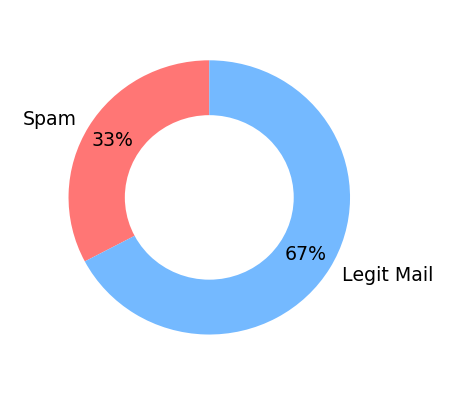

In [34]:
category_names = ['Spam', 'Legit Mail']
sizes = [amounts_of_spam, amounts_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2),dpi=227)
plt.pie(
    sizes,
    labels=category_names,
    textprops={'fontsize': 6},
    startangle=90,
    autopct='%1.0f%%',
    colors=custom_colours,
    pctdistance=0.8
)

# draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

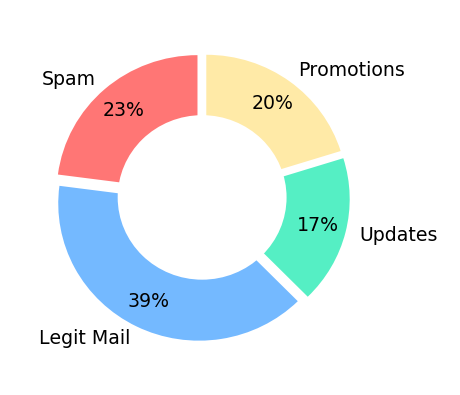

In [35]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2),dpi=227)
plt.pie(
    sizes,
    labels=category_names,
    textprops={'fontsize': 6},
    startangle=90,
    autopct='%1.0f%%',
    colors=custom_colours,
    pctdistance=0.8,
    explode=offset
)

# draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Text Pre-Processing

In [36]:
# cinvert to lower case
msg = 'All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/youn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /Users/youn/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/youn/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [39]:
msg = 'All work an no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/youn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Removing Stop Words

In [41]:
stop_words = set(stopwords.words('english'))

In [42]:
type(stop_words)

set

In [43]:
if 'this' in stop_words: print('Found it!')

Found it!


In [44]:
# Challenge: print out 'Nope. Not in here' if the word "hello" is not contained in stop_words

In [45]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [46]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [47]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
    Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [48]:
#'.'.isalpha()

In [49]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
    Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [50]:
soup = BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')
print(soup.prettify())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout
<http: optout="" www.insuranceiq.com

In [51]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

In [52]:
def clean_message(
    message,
    stemmer=PorterStemmer(),
    stop_words=set(stopwords.words('english'))
):
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [53]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [54]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2.
def clean_msg_no_html(
    message,
    stemmer=PorterStemmer(),
    stop_words=set(stopwords.words('english'))
):
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word)
    
    return filtered_words

In [55]:
clean_msg_no_html(data.at[2,'MESSAGE'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [56]:
data.iat[2,2]

'00214.1367039e50dc6b7adb0f2aa8aba83216'

In [57]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,------=_NextPart_000_00B8_51E06B6A.C8586B31\n\...,1,00187.efd97ab2034b3384606e21db00014ecb
6,"<STYLE type=""text/css"">\n\n<!--\n\nP{\n\n fon...",1,00500.85b72f09f6778a085dc8b6821965a76f
7,<HR>\n\n<html>\n\n<head>\n\n <title>Secured I...,1,00493.1c5f59825f7a246187c137614fb1ea82
8,"<table width=""600"" border=""20"" align=""center"" ...",1,00012.381e4f512915109ba1e0853a7a8407b2
9,"<html>\n\n\n\n<head>\n\n<meta http-equiv=""Cont...",1,00487.139a2f4e8edbbdd64441536308169d74
10,"Dear Consumers, Increase your Business Sales! ...",1,00159.b16f070a576c2eb1533aa9e2cf8e6b77


In [58]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [59]:
# flat_list  = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

390

In [60]:
flat_list

['dear',
 'homeown',
 'interest',
 'rate',
 'lowest',
 'point',
 'year',
 'help',
 'find',
 'best',
 'rate',
 'situat',
 'match',
 'need',
 'hundr',
 'lender',
 'home',
 'improv',
 'refin',
 'second',
 'mortgag',
 'home',
 'equiti',
 'loan',
 'even',
 'less',
 'perfect',
 'credit',
 'servic',
 'free',
 'home',
 'owner',
 'new',
 'home',
 'buyer',
 'without',
 'oblig',
 'fill',
 'quick',
 'simpl',
 'form',
 'futur',
 'plan',
 'today',
 'visit',
 'http',
 'unsubscrib',
 'pleas',
 'visit',
 'http',
 'attent',
 'must',
 'comput',
 'user',
 'packag',
 'deal',
 'norton',
 'systemwork',
 'softwar',
 'suit',
 'includ',
 'six',
 'ye',
 'util',
 'special',
 'low',
 'price',
 'softwar',
 'protect',
 'comput',
 'unwant',
 'hazard',
 'virus',
 'help',
 'secur',
 'privat',
 'valuabl',
 'inform',
 'allow',
 'transfer',
 'file',
 'send',
 'safe',
 'backup',
 'data',
 'quick',
 'easili',
 'improv',
 'pc',
 'perform',
 'integr',
 'diagnost',
 'util',
 'great',
 'price',
 'combin',
 'retail',
 'valu',
 '

In [61]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/Users/youn/miniconda3/envs/deeplearning101/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 31.9 s, sys: 129 ms, total: 32.1 s
Wall time: 32.1 s


In [62]:
nested_list.tail()

DOC_ID
5794    [one, work, well, week, te, updat, server, syn...
5795    [damien, morton, quot, approv, html, abl, say,...
5796    [mon, che, wrote, that, correct, line, ad, rep...
5797    [upon, time, manfr, wrote, would, like, instal...
5798    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

### Using Logic to Slice Datafames

In [63]:
data[data.CATEGORY == 1].shape

(1898, 3)

In [64]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1893,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,01311.43bfe86df65d53c5f7ca2365dc12582b
1894,<html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...,1,00851.dc5452f80ba0bb8481dfc48f70380c4d
1895,Hello:\n\n\n\nAre you satisfied with your ISP?...,1,01328.b23902de23cb3ca1f3334517282372b2
1896,<html><HEAD><TITLE>creditfix</TITLE> \n\n</HEA...,1,01244.9ef966101737a6fc27d8965def288d70
1897,<HTML><HEAD></HEAD><BODY><b><FONT SIZE=3D4>In ...,1,00788.b98a23c07d59156d172683fc29b80661


In [65]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which
# hold onto the indices for the spam and the non-spam emails respectively.

In [66]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [67]:
doc_ids_ham

Int64Index([1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
            ...
            5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798],
           dtype='int64', name='DOC_ID', length=3901)

### Subsetting a Series with an Index

In [68]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [69]:
type(nested_list)

pandas.core.series.Series

In [70]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [71]:
nested_list_ham.shape

(3901,)

In [72]:
nested_list_ham.tail()

DOC_ID
5794    [one, work, well, week, te, updat, server, syn...
5795    [damien, morton, quot, approv, html, abl, say,...
5796    [mon, che, wrote, that, correct, line, ad, rep...
5797    [upon, time, manfr, wrote, would, like, instal...
5798    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

In [73]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [74]:
# Challenge: use python list comprehension and then find the total number of 
# words in our cleaned dataset of spam email bodies. Also find the total number of
# words in normal emails in the dataset. Then find the 10 most common words used in 
# spam. Also, find the 10 most common words used in non-spam messages.

In [75]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20755

In [76]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [77]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in spam messages

13284

In [78]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

# Creating a Word Cloud

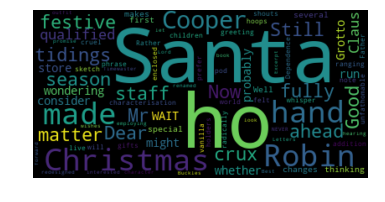

In [79]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [80]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [81]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [82]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [83]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

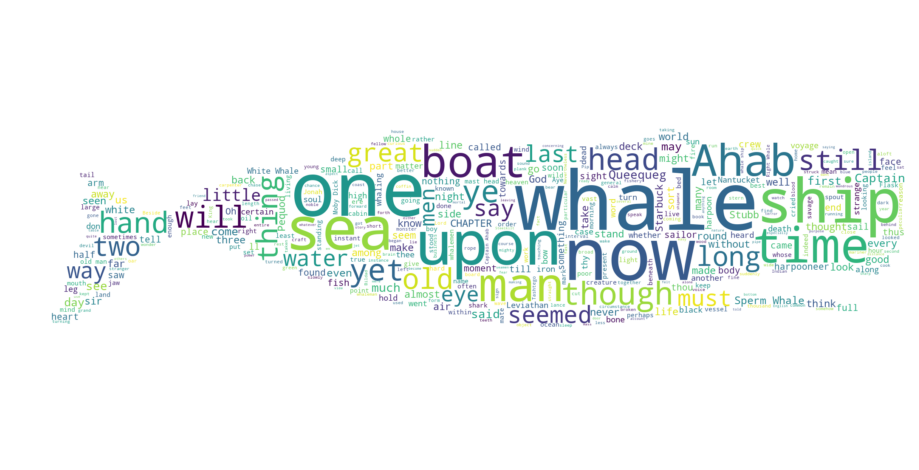

In [84]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #converts the image object to an array

word_cloud = WordCloud(
    mask=rgb_array,
    background_color='white',
    max_words=400
)
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [85]:
rgb_array.shape

(1024, 2048, 3)

In [86]:
rgb_array[1023,2047]

array([255, 255, 255], dtype=uint8)

In [87]:
rgb_array[500,1000]

array([0, 0, 0], dtype=uint8)

In [88]:
# challenge: use the skull image in the lesson resources to create a workd cloud
# for Shakespeare's play Hamlet

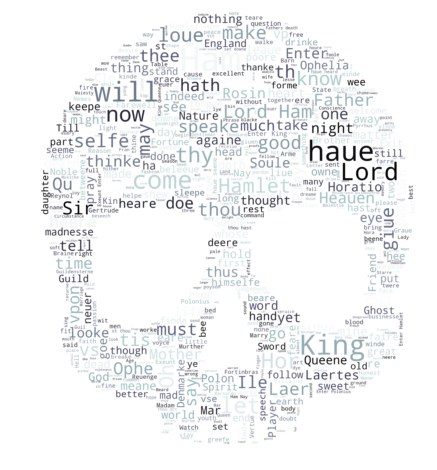

In [89]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255,255,255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(
    mask=rgb_array,
    background_color='white',
    colormap='bone',
    max_words=600
)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

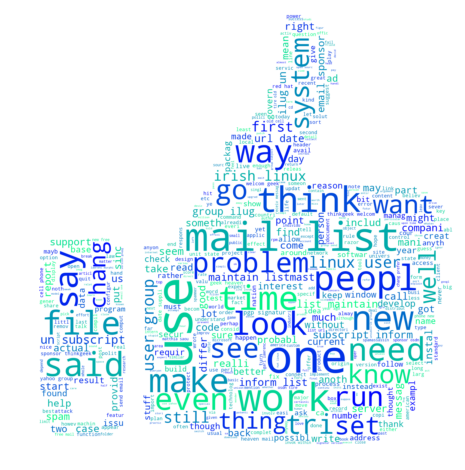

In [90]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(
    mask=rgb_array,
    background_color='white',
    max_words=500,
    colormap='winter'
)
word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [91]:
# Challenge: Look at the word cloud documentation. Use the custom font included in the
# lesson resources instead of the default font and create a word cloud of the spammy words

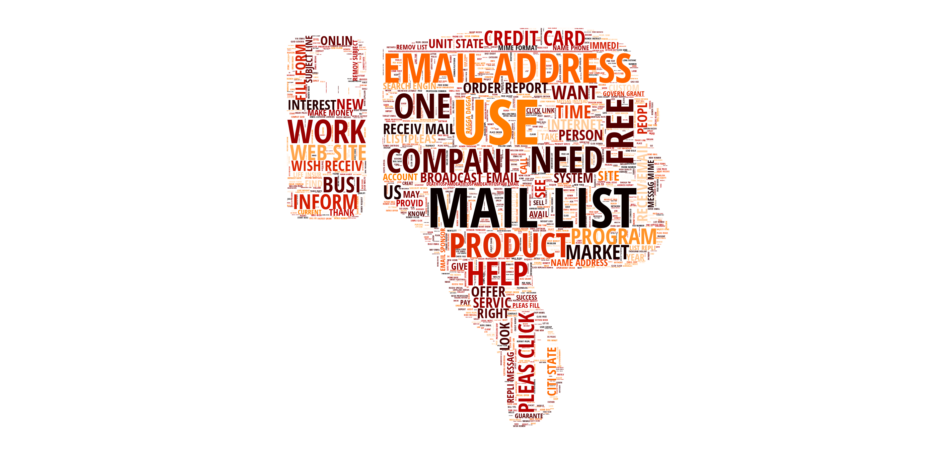

In [92]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(
    mask=rgb_array,
    background_color='white',
    max_words=2000,
    colormap='gist_heat',
    font_path=CUSTOM_FONT_FILE
)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [93]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [94]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27305


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [95]:
# Challenge: Create subset of the series called 'frequent_words' that only contains
# the most common 2,500 words out of the total. Print out the top 100 words

In [96]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [97]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD' : frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [98]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [99]:
# Challenge: Write a line of code that checks if a particular word is part
# of the vocabulary. Your code should return True if the word is among the
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [100]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [101]:
'brew' in set(vocab.VOCAB_WORD) # better way

False

# Exercise: Find the Email with the Most Number of Words

In [102]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension

In [103]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [104]:
print(clean_email_lengths)

[50, 80, 92, 77, 141, 1, 49, 132, 23, 74, 479, 45, 104, 128, 2, 72, 146, 45, 223, 178, 14, 129, 37, 97, 0, 274, 26, 835, 205, 54, 53, 50, 90, 738, 83, 78, 36, 34, 78, 36, 40, 0, 2, 202, 55, 10, 90, 90, 104, 18, 90, 104, 15, 58, 9, 117, 36, 226, 108, 389, 205, 249, 1262, 1216, 247, 34, 110, 748, 252, 77, 57, 196, 82, 34, 42, 81, 0, 269, 70, 95, 96, 79, 247, 80, 43, 74, 132, 90, 38, 9, 79, 208, 6, 177, 142, 25, 224, 0, 235, 132, 20, 14, 49, 166, 70, 664, 195, 317, 126, 108, 5, 223, 153, 8, 55, 372, 56, 97, 35, 115, 111, 25, 258, 835, 81, 86, 408, 25, 90, 90, 108, 673, 1389, 100, 175, 33, 329, 52, 65, 100, 58, 330, 2, 41, 3, 157, 146, 8, 97, 3, 27, 135, 1171, 157, 75, 20, 183, 273, 217, 333, 102, 50, 183, 19, 72, 217, 218, 61, 80, 112, 79, 60, 177, 43, 1183, 47, 657, 164, 13, 210, 58, 92, 124, 81, 78, 166, 89, 509, 509, 187, 84, 18, 117, 50, 0, 93, 157, 0, 47, 161, 62, 0, 6079, 208, 40, 61, 14, 0, 182, 84, 15, 185, 241, 144, 52, 93, 258, 72, 131, 216, 167, 38, 360, 80, 67, 213, 102, 0, 20

In [105]:
# Pythion List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [106]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 5404


In [107]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [108]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & Sparse Matrix
## Creating a DataFrame with one Word per Column

In [113]:
type(stemmed_nested_list[2])

list

In [115]:
type(stemmed_nested_list.tolist())

list

In [117]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


In [118]:
word_columns_df.shape

(5799, 7671)

### Splitting the Data into a Training and Testing Dataset

In [119]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%.
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data.
# What should the target values be?

In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    word_columns_df,
    data.CATEGORY,
    test_size=0.3,
    random_state=42
)

In [122]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4059
Fraction of training set 0.6999482669425763


In [127]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4925,hi,sorri,ot,wonder,anybodi,know,similar,type,mail,list,...,None,None,None,None,None,None,None,None,None,None
1103,messag,mime,format,wut,mba,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
812,import,notic,regard,domain,name,advis,regist,web,site,domain,...,None,None,None,None,None,None,None,None,None,None
1632,dear,sir,field,diesel,fuel,inject,system,quit,year,china,...,None,None,None,None,None,None,None,None,None,None
1128,freightmart,mail,campaign,remov,futur,offer,simpli,click,info,click,...,None,None,None,None,None,None,None,None,None,None


In [128]:
y_test.head()

DOC_ID
4925    0
1103    1
812     1
1632    1
1128    1
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [130]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [131]:
word_index.get_loc('thu')

396

In [134]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {
                    'LABEL': category,
                    'DOC_ID' : doc_id,
                    'OCCURENCE' : 1,
                    'WORD_ID' : word_id
                }
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [135]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 2min 16s, sys: 302 ms, total: 2min 17s
Wall time: 2min 16s


In [136]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4100,1,254
1,0,4100,1,268
2,0,4100,1,199
3,0,4100,1,45
4,0,4100,1,191


In [137]:
sparse_train_df.shape

(441683, 4)

In [138]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
441678,0,5390,1,119
441679,0,5390,1,1063
441680,0,5390,1,2178
441681,0,5390,1,402
441682,0,5390,1,316


### Combine Occurrences with the Pandas groupby() Method

In [139]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       7       1              1
       15      1              1
       18      1              1
       24      1              1

In [140]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [141]:
data.MESSAGE[0]

'Dear Homeowner,\n\n \n\nInterest Rates are at their lowest point in 40 years!\n\n\n\nWe help you find the best rate for your situation by\n\nmatching your needs with hundreds of lenders!\n\n\n\nHome Improvement, Refinance, Second Mortgage,\n\nHome Equity Loans, and More! Even with less than\n\nperfect credit!\n\n\n\nThis service is 100% FREE to home owners and new\n\nhome buyers without any obligation. \n\n\n\nJust fill out a quick, simple form and jump-start\n\nyour future plans today!\n\n\n\n\n\nVisit http://61.145.116.186/user0201/index.asp?Afft=QM10\n\n\n\n\n\n\n\n\n\n\n\n\n\nTo unsubscribe, please visit:\n\n\n\nhttp://61.145.116.186/light/watch.asp\n\n\n\n\n'

In [142]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,7,1,1
2,0,15,1,1
3,0,18,1,1
4,0,24,1,1


In [143]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
263291,5798,1885,0,1
263292,5798,1915,0,2
263293,5798,2137,0,1
263294,5798,2283,0,1
263295,5798,2488,0,1


In [148]:
vocab.at[1915, 'VOCAB_WORD']

'welch'

In [149]:
data.MESSAGE[5798]

'If you run Pick, and then use the "New FTOC" button to show only\n\nthose messages selected by pick, then the ftoc display was considered\n\n"invalid" in the old code.  This prevented the display from being cached,\n\nand it meant that you could get back to the full folder display by\n\nclicking on the folder lablel.  That doesn\'t work anymore.  You have\n\nto resort to Rescan Folder.  In fact, when you change folders you\n\ncontinue to have the Pick results, not the new folder contents.\n\nIf you go to a any folder and do Rescan, then it heals itself.\n\n--\n\nBrent Welch\n\nSoftware Architect, Panasas Inc\n\nPioneering the World\'s Most Scalable and Agile Storage Network\n\nwww.panasas.com\n\nwelch@panasas.com\n\n\n\n\n\n\n\n\n\n_______________________________________________\n\nExmh-workers mailing list\n\nExmh-workers@redhat.com\n\nhttps://listman.redhat.com/mailman/listinfo/exmh-workers\n\n\n\n\n'

### Save Training Data as .txt File

In [151]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [152]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

can you create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file.

In [154]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4925,hi,sorri,ot,wonder,anybodi,know,similar,type,mail,list,...,None,None,None,None,None,None,None,None,None,None
1103,messag,mime,format,wut,mba,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
812,import,notic,regard,domain,name,advis,regist,web,site,domain,...,None,None,None,None,None,None,None,None,None,None
1632,dear,sir,field,diesel,fuel,inject,system,quit,year,china,...,None,None,None,None,None,None,None,None,None,None
1128,freightmart,mail,campaign,remov,futur,offer,simpli,click,info,click,...,None,None,None,None,None,None,None,None,None,None


In [155]:
y_test.head()

DOC_ID
4925    0
1103    1
812     1
1632    1
1128    1
Name: CATEGORY, dtype: int64

In [156]:
X_test.shape

(1740, 7671)

In [157]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 1min, sys: 179 ms, total: 1min
Wall time: 1min


In [160]:
sparse_test_df.shape

(192450, 4)

In [161]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,19,1,2
4,8,26,1,1


In [162]:
test_grouped.shape

(112705, 4)

In [164]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing.

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out

In [165]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [167]:
len(test_doc_ids)

1724

In [168]:
len(X_test)

1740

In [172]:
set(X_test.index.values) - test_doc_ids

{14,
 227,
 290,
 315,
 350,
 408,
 453,
 465,
 577,
 794,
 857,
 1002,
 1055,
 1480,
 1536,
 1872}

In [173]:
data.MESSAGE[14]

'------=_NextPart_000_00A3_65E24E1C.A3468E63\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nQ09QWSBEVkQgTU9WSUVTIFRPIENELVINClJJR0hUIE5PVyENCg0KDQpXZSBo\n\nYXZlIEFsbCB0aGUgc29mdHdhcmUgeW91IG5lZWQgdG8gQ09QWSB5b3VyIG93\n\nbiBEVkQgTW92aWVzLg0KDQpDb3B5IHlvdXIgb3duIERWRCBNb3ZpZXMgdXNp\n\nbmcgbm90aGluZyBtb3JlIHRoYW4gb3VyIHNvZnR3YXJlLCBhIA0KRFZELVJP\n\nTSBhbmQgeW91ciBDRC1SIGJ1cm5lciENCg0KQmFja3VwIHlvdXIgRFZEIE1v\n\ndmllIENvbGxlY3Rpb24gDQpQbGF5YmFjayBvbiBhbnkgaG9tZSBEVkQgcGxh\n\neWVyKiANCk5vIEV4cGVuc2l2ZSBEVkQgQnVybmVyIFJlcXVpcmVkIA0KRnJl\n\nZSBMaXZlIFRlY2ggU3VwcG9ydA0KDQogDQpMSU1JVEVEIFRJTUUgT0ZGRVIh\n\nIEZSRUUgRFZEIE1PVklFIE9GIFlPVVIgQ0hPSUNFISBBQ1QgTk9XIQ0KDQoN\n\nCjxhIGhyZWY9Imh0dHA6Ly8yMDIuMTA4LjIyMS4xOC93d3cyODIvcG9zL2R2\n\nZC5odG0iPmNsaWNrIGhlcmU8L2E+DQoNCisrKysrKysrKysrKysrKysrKysr\n\nKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysr\n\nKysrKysrKysrKysNClRoaXMgZW1haWwgaGFzIGJlZW4gc2NyZWVuZWQgYW5k\n\nIGZpbHRlcmVkIGJ5IG91ciBpb

In [174]:
data.loc[14]

MESSAGE      ------=_NextPart_000_00A3_65E24E1C.A3468E63\n\...
CATEGORY                                                     1
FILE_NAME               00095.17594a58d6736a8f6a1990b0b92090cd
Name: 14, dtype: object

In [175]:
clean_msg_no_html(data.at[14,'MESSAGE'])

['kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr',
 'kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr']

In [176]:
data.MESSAGE[1096]

'<html>\n\n<head>\n\n   <meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1">\n\n   <title>Lowest Viagra Prices Online!</title>\n\n</head>\n\n<body>\n\n<table COLS=1 WIDTH="538" >\n\n<tr>\n\n<td><font face="Arial,Helvetica">We are the largest U.S. Company specializing\n\nin prescriptions for <b><font color="#3333FF"><a href="http://www.1-stopshop.net">VIAGRA</a></font></b>,\n\nweight loss management and other FDA approved medications.&nbsp;</font>\n\n<p><font face="Arial,Helvetica">It has never been easier to get <b><font color="#3366FF"><a href="http://www.1-stopshop.net">Viagra</a></font></b>.&nbsp;</font>\n\n<p><b><font face="Arial,Helvetica">No Physical Exam Necessary!</font></b>\n\n<ul>\n\n<li>\n\n<font face="Arial,Helvetica">Free online consultation</font></li>\n\n\n\n<li>\n\n<font face="Arial,Helvetica">Fully confidential</font></li>\n\n\n\n<li>\n\n<font face="Arial,Helvetica">No embarassment&nbsp;</font></li>\n\n\n\n<li>\n\n<font face="Arial,Helvetica">No app

In [179]:
clean_msg_no_html(data.at[1090, 'MESSAGE'])

['receiv',
 'email',
 'subscrib',
 'enetwork',
 'mail',
 'list',
 'remov',
 'relat',
 'email',
 'list',
 'click',
 'unsubscrib',
 'email',
 'bill',
 'titl',
 'iii',
 'us',
 'congress',
 'per',
 'section',
 'paragraph',
 'letter',
 'consid',
 'spam',
 'sender',
 'includ',
 'contact',
 'inform',
 'method',
 'remov']

In [180]:
clean_message(data.at[1096, 'MESSAGE'])

['html',
 'head',
 'meta',
 'titl',
 'lowest',
 'viagra',
 'price',
 'onlin',
 'bodi',
 'tabl',
 'tr',
 'td',
 'font',
 'arial',
 'helvetica',
 'largest',
 'compani',
 'special',
 'prescript',
 'b',
 'font',
 'http',
 'viagra',
 'weight',
 'loss',
 'manag',
 'fda',
 'approv',
 'nbsp',
 'p',
 'font',
 'arial',
 'helvetica',
 'never',
 'easier',
 'get',
 'b',
 'font',
 'http',
 'viagra',
 'nbsp',
 'p',
 'b',
 'font',
 'arial',
 'helvetica',
 'physic',
 'exam',
 'necessari',
 'ul',
 'li',
 'font',
 'arial',
 'helvetica',
 'free',
 'onlin',
 'consult',
 'li',
 'font',
 'arial',
 'helvetica',
 'fulli',
 'confidenti',
 'li',
 'font',
 'arial',
 'helvetica',
 'embarass',
 'nbsp',
 'li',
 'font',
 'arial',
 'helvetica',
 'appoint',
 'li',
 'font',
 'arial',
 'helvetica',
 'secur',
 'order',
 'nbsp',
 'li',
 'font',
 'arial',
 'helvetica',
 'discreet',
 'overnight',
 'ship',
 'nbsp',
 'p',
 'br',
 'b',
 'font',
 'arial',
 'helvetica',
 'font',
 'http',
 'guarante',
 'lowest',
 'p',
 'b',
 'font